# Multicalss Image Classification Using EfficentNet
## Import and Setup path

In [2]:
# !pip install opencv-python tensorflow pydot

In [3]:
# !pip list

In [34]:
# General Libraries
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns  # Commented out as it's not currently used

# Data Processing Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Activation, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

# Matplotlib Libraries
from matplotlib.pyplot import imread, imshow

# ImageNet Utilities from TensorFlow Keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input


In [5]:
#Setting Training dir paths
train_path = './Data/'
#Setting Test dir paths
test_path = './Data_test/'

## Exploratory Data Analysis

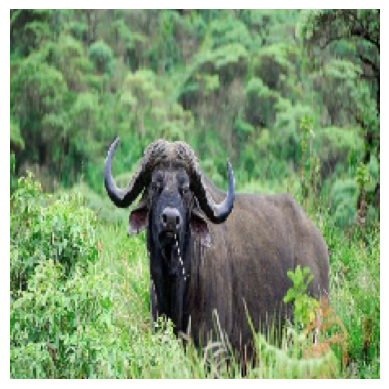

In [6]:
#Displaying the image
img = load_img(train_path + "Buffalo/Buffalo_1.jpg", target_size=(227,227))
plt.imshow(img)
plt.axis("off")
plt.show()

In [7]:
#Printing the shape of the image array
x = img_to_array(img)
print(x.shape)

(227, 227, 3)


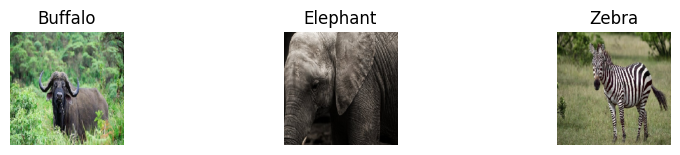

In [8]:
#Visualizing more Images from each class
images = ['Buffalo', 'Elephant', 'Zebra']
fig = plt.figure(figsize =(10,5))
for i in range(len(images)):
    ax = fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    plt.title(images[i])
    plt.axis("off")
    ax.imshow(load_img(train_path + images[i] +'/'+images[i]+"_1.jpg", target_size=(227,227)))

In [9]:
#Getting the count of images for each class
image_count = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
#Reading the image from each folder from training path
for folder in os.listdir(train_path):
    folder_num = len(os.listdir(os.path.join(train_path,folder)))
    image_count.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
print('-' * 24)
print("Number of classes : ",len(class_names))

class             Count:
------------------------
Buffalo              1000
Elephant             1000
Zebra                1000
------------------------
Number of classes :  3


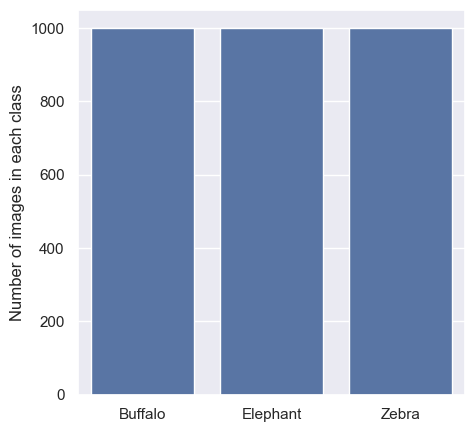

In [10]:
#Plotting the count of images for each class
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(x=class_names, y=image_count)
plt.ylabel('Number of images in each class')
plt.show()

In [11]:
#Finding number of classes
className = glob(train_path + '/*')
num_classes = len(className)
print(num_classes)

3


## Pre Processing

In [24]:
dataset_path = os.listdir('Data')

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir('Data' + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('Data' + '/' +item) + '/' + room))
    #print(class_labels[:5])

['Buffalo', 'Elephant', 'Zebra']
Types of classes labels found:  3


In [25]:
# Build a dataframe        
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

    Labels                          image
0  Buffalo     Data/Buffalo/Buffalo_1.jpg
1  Buffalo    Data/Buffalo/Buffalo_10.jpg
2  Buffalo   Data/Buffalo/Buffalo_100.jpg
3  Buffalo  Data/Buffalo/Buffalo_1000.jpg
4  Buffalo   Data/Buffalo/Buffalo_101.jpg
     Labels                     image
2995  Zebra  Data/Zebra/Zebra_995.jpg
2996  Zebra  Data/Zebra/Zebra_996.jpg
2997  Zebra  Data/Zebra/Zebra_997.jpg
2998  Zebra  Data/Zebra/Zebra_998.jpg
2999  Zebra  Data/Zebra/Zebra_999.jpg


In [26]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  3000
Labels
Buffalo     1000
Elephant    1000
Zebra       1000
Name: count, dtype: int64


In [27]:
path = 'Data/'
dataset_path = os.listdir('Data')

im_size = 224
num_images_to_pick = 800

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
    
    selected_filenames = filenames[:num_images_to_pick] 
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, selected_filenames))
        images.append(img)
        labels.append(i)

In [28]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(3000, 224, 224, 3)

In [29]:
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['Buffalo' 'Buffalo' 'Buffalo' ... 'Zebra' 'Zebra' 'Zebra']
[0 0 0 ... 2 2 2]


In [31]:
y=y.reshape(-1,1)

ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [32]:
images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2850, 224, 224, 3)
(2850, 3)
(150, 224, 224, 3)
(150, 3)


# Model using EfficientNet Implementation

In [33]:
NUM_CLASSES = 3
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [ ]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()

hist = model.fit(train_x, train_y, epochs=30, verbose=2)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

# Testing Efficient Model On Unseen data

In [ ]:
img_path = '/Data_Test/unseen-1.png'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [ ]:
preds=model.predict(x)
preds     # probabilities for being in each of the 3 classes